<a href="https://colab.research.google.com/github/oolonglilfox/CSC2516Project/blob/main/csc413_group200_Art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [ ]:
!pip install kornia cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Libraries
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import InterpolationMode
import numpy as np
import csv
import os
import io
import kornia
import time
from tqdm import tqdm
from PIL import Image
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake deeplake[enterprise]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB

In [ ]:
# create dataloader by chaining with transform function and batch size and returns batch of pytorch tensors
import deeplake
import gc
# Load the original dataset
# ds = deeplake.load('hub://activeloop/wiki-art')
ds = deeplake.load('/content/drive/MyDrive/Colab Notebooks/hub_activeloop_wiki-art')
ok, train_ds, test_ds = ds.random_split([0.7, 0.25, 0.05])
ok=None
gc.collect()

|

/content/drive/MyDrive/Colab Notebooks/hub_activeloop_wiki-art loaded successfully.



0

In [ ]:
classes = [
  "abstract_expressionism",
  "action_painting",
  "analytical_cubism",
  "art_nouveau_modern",
  "baroque",
  "color_field_painting",
  "contemporary_realism",
  "cubism",
  "early_renaissance",
  "expressionism",
  "fauvism",
  "high_renaissance",
  "impressionism",
  "mannerism_late_renaissance",
  "minimalism",
  "naive_art_primitivism",
  "new_realism",
  "northern_renaissance",
  "pointillism",
  "pop_art",
  "post_impressionism",
  "realism",
  "rococo",
  "romanticism",
  "symbolism",
  "synthetic_cubism",
  "ukiyo_e"
 ]

# Model Building


In [ ]:
class BasicBlock(nn.Module):
   # define basic building block of a ResNet - a two-layer convolutiona neural network with a residual connection
    expansion = 1 # class-level variable

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # define the 2 convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # define shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    # building block needed in the ResNet architecture
    expansion = 4 # adjust number of output channels in residual branch of the block
    
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class denoising_block(nn.Module):
    def __init__(self, in_planes, ksize, filter_type):
        super(denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median_Filter':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean_Filter':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian_Filter':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, whether_denoising=False, filter_type="Mean_Filter", ksize=3):
        super(ResNet, self).__init__()
        if whether_denoising:
            self.denoising_block1 = denoising_block(in_planes=64, ksize=ksize, filter_type=filter_type)
            self.denoising_block2 = denoising_block(in_planes=64, ksize=ksize, filter_type=filter_type)
        self.whether_denoising = whether_denoising
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.whether_denoising:
            out = self.denoising_block1(out)
        out = self.layer1(out)
        if self.whether_denoising:
            out = self.denoising_block2(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
def ResNet18(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=len(classes), whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet34(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=len(classes), whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet50(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=len(classes), whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet101(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=len(classes), whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet152(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=len(classes), whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def test():
    from torch.autograd import Variable
    net = ResNet18(whether_denoising=True, filter_type="Median_Filter", ksize=3)
    x = Variable(torch.randn(1, 3, 32, 32), requires_grad=True)
    y = net(x)
    print(y)

def denoising_block_test(filter_type):
    from torch.autograd import Variable
    denoising_block1 = denoising_block(in_planes=32, ksize=3, filter_type=filter_type)
    x = Variable(torch.ones(2, 64, 32, 32), requires_grad=True)
    y = denoising_block1(x)
    print(y)
    y.backward(x)
    print(x.grad)

# Data transformation
Countering Adversarial Images Using Input Transformations

In [ ]:
import math

def denoise_tv_bregman(image, weight, max_iter=100, eps=1e-3):
  if image.is_cuda:
    image = image.cpu()
  image = atleast_3d(image)

  img_shape = list(image.shape)
  rows = img_shape[0]
  rows2 = rows + 2
  cols = img_shape[1]
  cols2 = cols + 2
  dims = img_shape[2]
  total = rows * cols * dims
  shape_extend = (rows2, cols2, dims)
  # out is firstly created as zeros-like tensor with size as shape_extend
  out = torch.zeros(shape_extend, dtype=torch.float)

  dx = out.clone().detach()
  dy = out.clone().detach()
  bx = out.clone().detach()
  by = out.clone().detach()

  lam = 2 * weight
  rmse = float("inf")
  norm = (weight + 4 * lam)

  out_rows, out_cols = out.shape[:2]
  out[1:out_rows-1, 1:out_cols-1] = image

  out = fill_extend(image, out)

  i = 0
  regularization = torch.mul(image, weight)
  # iterative optimization method
  # split-Bregman iteration
  while i < max_iter and rmse > eps:
    uprev = out[1:-1, 1:-1, :]

    ux = out[1:-1, 2:, :] - uprev
    uy = out[2:, 1:-1, :] - uprev

    unew = torch.div(
        (torch.mul((out[2:, 1:-1, :]
                + out[0:-2, 1:-1, :]
                + out[1:-1, 2:, :]
                + out[1:-1, 0:-2, :]

                + dx[1:-1, 0:-2, :]
                - dx[1:-1, 1:-1, :]
                + dy[0:-2, 1:-1, :]
                - dy[1:-1, 1:-1, :]

                - bx[1:-1, 0:-2, :]
                + bx[1:-1, 1:-1, :]
                - by[0:-2, 1:-1, :]
                + by[1:-1, 1:-1, :]), lam) + regularization),
          norm)
    out[1:-1, 1:-1, :] = unew.clone().detach()

    rmse = torch.norm(unew-uprev, p=2)

    bxx = bx[1:-1, 1:-1, :].clone().detach()
    byy = by[1:-1, 1:-1, :].clone().detach()

    tx = ux + bxx
    ty = uy + byy
    s = torch.sqrt(torch.pow(tx, 2)+torch.pow(ty, 2))
    dxx = torch.div(torch.addcmul(torch.zeros(s.shape, dtype=torch.float), lam, s, tx),
                    torch.add(torch.mul(s, lam), 1))
    dyy = torch.div(torch.addcmul(torch.zeros(s.shape, dtype=torch.float), lam, s, ty),
                    torch.add(torch.mul(s, lam), 1))

    dx[1:-1, 1:-1, :] = dxx.clone().detach()
    dy[1:-1, 1:-1, :] = dyy.clone().detach()

    bx[1:-1, 1:-1, :] += ux - dxx
    by[1:-1, 1:-1, :] += uy - dyy

    i += 1
  # return the denoised image excluding the extended area
  return out[1:-1, 1:-1]

def atleast_3d(image):
    dim = list(image.shape)

    if len(dim) >= 3:
        return image
    else:
        dim.append(1)
        return image.view(dim)

def fill_extend(image, out):
    """fill the extended area in out img with original img"""
    out_rows, out_cols = out.shape[:2]
    rows, cols = out_rows - 2, out_cols - 2
    out[0, 1:out_cols-1] = image[1, :]
    out[1:out_rows-1, 0] = image[:, 1]
    out[out_rows-1, 1:out_cols-1] = image[rows-1, :]
    out[1:out_rows-1, out_cols-1] = image[:, cols-1]
    return out

def randomJPEGcompression(image):
    qf = np.random.randint(10, 101)
    if torch.is_tensor(image):
      image = transforms.ToPILImage()(image)
    outputIoStream = io.BytesIO()
    
    image.save(outputIoStream, "JPEG", quality=qf, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

def tvDenoising(image):
  return denoise_tv_bregman(image, weight=0.1)


In [ ]:
image_transforms = {
  'cropping_rescaling':
  transforms.Compose([
      transforms.RandomResizedCrop(size=32),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])  # Imagenet standards
  ]),
  'bit_depth_reduction':
  transforms.Compose([
      transforms.RandomPosterize(4, p=0.5),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'JEPG_compression':
  transforms.Compose([
      transforms.Lambda(randomJPEGcompression),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'TVDenoise':
  transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(tvDenoising),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'cropping_rescaling_attack':
  transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomResizedCrop(size=32),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])  # Imagenet standards
  ]),
  'bit_depth_reduction_attack':
  transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomPosterize(4, p=0.5),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'JEPG_compression_attack':
  transforms.Compose([
      transforms.Lambda(randomJPEGcompression),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'TVDenoise_attack':
  transforms.Compose([
      transforms.Lambda(tvDenoising),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
}

# Training

In [ ]:
import torch.backends.cudnn as cudnn

whether_denoising=True
filter_type='Mean_Filter'
ksize=3
learning_rate=1e-3
epochs=20
batch_size=64
num_workers=4
GPU='0'
# model_address = "/content/drive/MyDrive/Colab Notebooks/TrueMean_Filter3.pkl"
basic_model = 'ResNet18'
filter_type = 'Mean_Filter'
kernel_size = 3
perturbation_threshold = 1e-8
weight_decay = 1e-4
momentum = 0.9

os.environ["CUDA_VISIBLE_DEVICES"] = GPU


# set the device to be used
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# enable benchmark mode for the cuDNN library
cudnn.benchmark = True

In [ ]:
def test(model, testloader, criterion):
    model.eval()
    correct, total, loss, counter = 0, 0, 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device) # move data to GPU
            labels = labels.to(device).squeeze() # move data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).item()
            counter += 1
    return loss / total, correct / total


transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(512),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

testloader = test_ds.pytorch(tensors=["image", "label"], transform = {'images': transform_test, 'labels': None}, num_workers=num_workers, batch_size=batch_size, decode_method={'images': 'numpy'}, pin_memory=True)
# testloader = test_ds.dataloader()\
#     .transform({'images': transform_test, 'labels': None})\
#     .batch(batch_size)\
#     .pytorch(num_workers=num_workers, return_index=False, decode_method={'images': 'numpy'})

def train(whether_denoising, filter_type, ksize, epochs, transform=None):
    if transform:
        transform_train = image_transforms[transform]

    else:
        # Set the transformation
        transform_train = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop(512),
            transforms.Resize(32),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])


    # Load the dataset
    trainloader = train_ds.pytorch(tensors=["image", "label"], transform = {'images': transform_train, 'labels': None}, num_workers=num_workers, batch_size=batch_size, decode_method={'images': 'numpy'}, pin_memory=True)
    # trainloader = train_ds.dataloader()\
    #     .transform({'images': transform_train, 'labels': None})\
    #     .batch(batch_size)\
    #     .pytorch(num_workers=num_workers, return_index=False, decode_method={'images': 'numpy'})

    # Establish the model
    model = ResNet18(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device) # move model to GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=True)
    scheduler = MultiStepLR(optimizer, milestones=[int(epochs/2), int(epochs*3/4), int(epochs*7/8)], gamma=0.1)

    total, correct, train_loss = 0, 0, 0
    best_acc, best_epoch = 0, 0

    for epoch in range(epochs):
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels = data
            inputs = inputs.to(device) # move data to GPU
            labels = labels.to(device).squeeze() # move data to GPU
            model.train()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # count acc,loss on trainset
            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            train_loss += loss.item()
        
        acc = correct / total
        train_loss /= total
        val_loss, val_acc = test(model, testloader, criterion)
        
        print("epoch:{}, train_loss:{:.3f}, train_acc:{:.3f}, val_loss:{:.3f}, val_acc:{:.3f}".format(epoch, train_loss, acc, val_loss, val_acc))
        correct, total, train_loss = 0, 0, 0
        if best_acc < val_acc:
            best_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Art_" + str(whether_denoising) + filter_type + str(transform) + '.pkl')
    print("Best model at present: val_acc={:.3f}  best_epoch={}".format(best_acc, best_epoch))
    return model


# Adversarial Attack

In [ ]:
def evaluate_attack(testset, attack_method, norm, epsilon, model, transform=None):
    # load dataset
    test_loader = testset

    # run evaluation
    model.eval()
  
    correct = 0.0
    for images, labels in test_loader:
      images, labels = images.cuda(), labels.cuda().squeeze()

      if attack_method == 'baseline' or epsilon == 0.0:
          pass
      elif attack_method == 'fgsm':
          images = fast_gradient_method(
              model_fn=model,
              x=images,
              eps=epsilon,
              norm=norm,
              clip_min=0.0,
              clip_max=1.0,
          )

      if transform == None:
        with torch.no_grad():
            out = model(images)
            _, preds = torch.max(out, 1)
            correct += torch.sum(preds == labels).detach().cpu()
      else:
        transform_methods=image_transforms[transform]
        for img in images:
          img = transform_methods(img)
        with torch.no_grad():
            out = model(images)
            _, preds = torch.max(out, 1)
            correct += torch.sum(preds == labels).detach().cpu()


      acc = correct / len(test_loader.dataset)
  
    return acc

In [ ]:
def load_model(basic_model, whether_denoising, filter_type, ksize):
    if basic_model == 'ResNet18':
        model = ResNet18(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet34':
        model = ResNet34(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet50':
        model = ResNet50(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet101':
        model = ResNet101(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet152':
        model = ResNet152(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

    model.cuda()
    model = DataParallel(model)
    return model


# Plotting


In [ ]:
def plottingAttack(modelsInfo, epsilon_range, testloader):
  epsilons = np.linspace(epsilon_range[0], epsilon_range[1], 10)
  os.environ["CUDA_VISIBLE_DEVICES"] = GPU
  for info in modelsInfo:
    model = load_model(basic_model=basic_model, 
                       whether_denoising=info['whether_denoising'], 
                       filter_type=info['filter_type'], ksize=kernel_size)
    model.load_state_dict(torch.load(info['address']), strict=False)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device) # move model to GPU
    attack_acc = []
    plt.xlabel('epsilon')
    plt.ylabel('test_acc')
    for eps in tqdm(epsilons):
      if info['transform']:
        attack_acc.append(evaluate_attack(testloader, 'fgsm', 2, eps, model, transform = info['transform']+"_attack"))
      else:
        attack_acc.append(evaluate_attack(testloader, 'fgsm', 2, eps, model))
    if info['whether_denoising'] and info['transform']:
      label = info['filter_type'] + "+" + info['transform']
    elif info['whether_denoising'] :
      label = info['filter_type'] 
    elif info['transform']:
      label = info['transform']
    else:
      label = 'Baseline'
    plt.plot(epsilons, attack_acc, label = label)
  plt.legend()
  plt.show()



In [ ]:
model = train(False, filter_type, ksize, epochs, transform=None)

100%|██████████| 319/319 [08:34<00:00,  1.61s/it]


epoch:0, train_loss:0.050, train_acc:0.133, val_loss:0.046, val_acc:0.194


100%|██████████| 319/319 [08:36<00:00,  1.62s/it]


epoch:1, train_loss:0.046, train_acc:0.173, val_loss:0.046, val_acc:0.177


100%|██████████| 319/319 [08:23<00:00,  1.58s/it]


epoch:2, train_loss:0.046, train_acc:0.182, val_loss:0.046, val_acc:0.176


100%|██████████| 319/319 [08:25<00:00,  1.58s/it]


epoch:3, train_loss:0.045, train_acc:0.187, val_loss:0.046, val_acc:0.174


100%|██████████| 319/319 [08:32<00:00,  1.61s/it]


epoch:4, train_loss:0.045, train_acc:0.192, val_loss:0.045, val_acc:0.180


100%|██████████| 319/319 [08:25<00:00,  1.59s/it]


epoch:5, train_loss:0.046, train_acc:0.189, val_loss:0.046, val_acc:0.154


100%|██████████| 319/319 [08:29<00:00,  1.60s/it]


epoch:6, train_loss:0.045, train_acc:0.188, val_loss:0.046, val_acc:0.179


100%|██████████| 319/319 [08:18<00:00,  1.56s/it]


epoch:7, train_loss:0.045, train_acc:0.195, val_loss:0.046, val_acc:0.169


100%|██████████| 319/319 [08:23<00:00,  1.58s/it]


epoch:8, train_loss:0.045, train_acc:0.196, val_loss:0.046, val_acc:0.176


100%|██████████| 319/319 [08:22<00:00,  1.57s/it]


epoch:9, train_loss:0.044, train_acc:0.199, val_loss:0.046, val_acc:0.169


100%|██████████| 319/319 [08:24<00:00,  1.58s/it]


epoch:10, train_loss:0.044, train_acc:0.198, val_loss:0.046, val_acc:0.172


100%|██████████| 319/319 [08:20<00:00,  1.57s/it]


epoch:11, train_loss:0.044, train_acc:0.201, val_loss:0.046, val_acc:0.171


100%|██████████| 319/319 [08:21<00:00,  1.57s/it]


epoch:12, train_loss:0.044, train_acc:0.203, val_loss:0.046, val_acc:0.173


100%|██████████| 319/319 [08:25<00:00,  1.58s/it]


epoch:13, train_loss:0.044, train_acc:0.203, val_loss:0.046, val_acc:0.188


100%|██████████| 319/319 [08:26<00:00,  1.59s/it]


epoch:14, train_loss:0.043, train_acc:0.206, val_loss:0.046, val_acc:0.177


100%|██████████| 319/319 [08:22<00:00,  1.58s/it]


epoch:15, train_loss:0.043, train_acc:0.210, val_loss:0.046, val_acc:0.181


100%|██████████| 319/319 [08:21<00:00,  1.57s/it]


epoch:16, train_loss:0.043, train_acc:0.210, val_loss:0.045, val_acc:0.188


100%|██████████| 319/319 [08:22<00:00,  1.58s/it]


epoch:17, train_loss:0.043, train_acc:0.216, val_loss:0.046, val_acc:0.196


100%|██████████| 319/319 [08:25<00:00,  1.58s/it]


epoch:18, train_loss:0.042, train_acc:0.214, val_loss:0.046, val_acc:0.191


100%|██████████| 319/319 [08:24<00:00,  1.58s/it]


epoch:19, train_loss:0.042, train_acc:0.216, val_loss:0.046, val_acc:0.192
Best model at present: val_acc=0.196  best_epoch=17


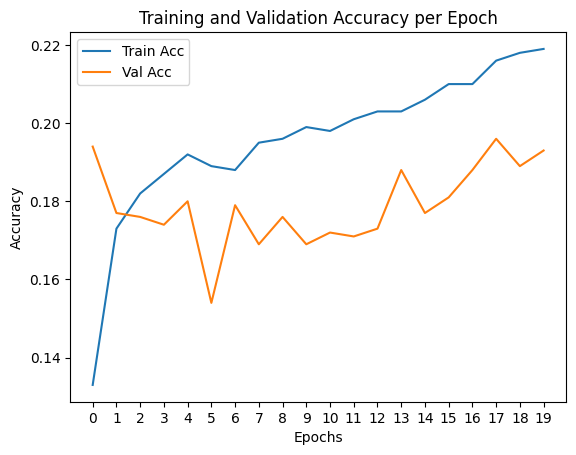

In [ ]:
import matplotlib.pyplot as plt

# Data
epoch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
train_acc = [0.133, 0.173, 0.182, 0.187, 0.192, 0.189, 0.188, 0.195, 0.196, 0.199, 0.198, 0.201, 0.203, 0.203, 0.206, 0.210, 0.210, 0.216, 0.218, 0.219]
val_acc = [0.194, 0.177, 0.176, 0.174, 0.180, 0.154, 0.179, 0.169, 0.176, 0.169, 0.172, 0.171, 0.173, 0.188, 0.177, 0.181, 0.188, 0.196, 0.189, 0.193]

# Plotting
plt.plot(epoch, train_acc, label='Train Acc')
plt.plot(epoch, val_acc, label='Val Acc')
plt.title('Training and Validation Accuracy per Epoch')
plt.xticks(epoch)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model = load_model(basic_model=basic_model, 
                   whether_denoising=False, 
                   filter_type=filter_type, ksize=kernel_size)
model.cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Art_FalseMean_FilterNone.pkl'), strict=False)

# evaluate_attack(testloader, 'fgsm', 2, 3, model, transform = None)

_IncompatibleKeys(missing_keys=['module.module.conv1.weight', 'module.module.bn1.weight', 'module.module.bn1.bias', 'module.module.bn1.running_mean', 'module.module.bn1.running_var', 'module.module.layer1.0.conv1.weight', 'module.module.layer1.0.bn1.weight', 'module.module.layer1.0.bn1.bias', 'module.module.layer1.0.bn1.running_mean', 'module.module.layer1.0.bn1.running_var', 'module.module.layer1.0.conv2.weight', 'module.module.layer1.0.bn2.weight', 'module.module.layer1.0.bn2.bias', 'module.module.layer1.0.bn2.running_mean', 'module.module.layer1.0.bn2.running_var', 'module.module.layer1.1.conv1.weight', 'module.module.layer1.1.bn1.weight', 'module.module.layer1.1.bn1.bias', 'module.module.layer1.1.bn1.running_mean', 'module.module.layer1.1.bn1.running_var', 'module.module.layer1.1.conv2.weight', 'module.module.layer1.1.bn2.weight', 'module.module.layer1.1.bn2.bias', 'module.module.layer1.1.bn2.running_mean', 'module.module.layer1.1.bn2.running_var', 'module.module.layer2.0.conv1.wei

100%|██████████| 10/10 [16:09<00:00, 96.97s/it]


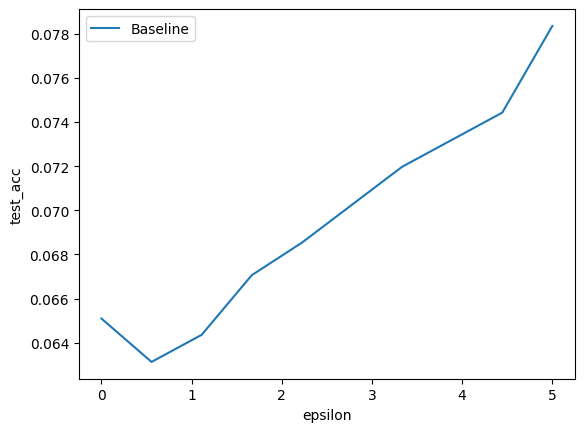

In [ ]:
modelsInfo = [{'whether_denoising': False, 
               'filter_type': 'Mean_Filter', 
               'transform': None,
               'address':'/content/drive/MyDrive/Colab Notebooks/Art_FalseMean_FilterNone.pkl'}]
epsilon_range = [0.0,5]
plottingAttack(modelsInfo, epsilon_range, testloader)

# Reference

Adversarial attack:
* https://github.com/JasonTang99/csc2529_project/blob/main/attack.py
* https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans/jax/attacks/fast_gradient_method.py


Countering Adversarial Images Using Input Transformations:
* https://github.com/facebookarchive/adversarial_image_defenses
* https://arxiv.org/pdf/1812.03411.pdf

Data Transformation: 
* https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/
* JPEG tranformation: https://discuss.pytorch.org/t/how-can-i-develop-a-transformation-that-performs-jpeg-compression-with-a-random-qf/43588/4
* TV denoise using bregman algorithm: https://github.com/shakes76/PatternFlow/blob/master/algorithms/denoise/denoise_tv_bregman/denoise_tv_bregman.py

Others:
* https://github.com/tqdm/tqdm


# Others
Parameters
1. A graph compare: Median_Filter, Mean_Filter, Gaussian_Filter, baseline
2. A graph compare: 4 transformations, baseline
3. A graph compare: best transformation + best filter, best filter, best transformation, baseline